# SPIRE FTS data access and data analysis in python 3

## Introduction

The Herschel Science Archive has a I/O interface called HAIO. How to use it is explained in some details in this url http://archives.esac.esa.int/hsa/aio/doc/howto.html

In order to access Herschel data, one can construct an HAIO HTTP request and submit it to the archive.

In the following example, we download SPIRE FTS level-2 data as a tar file, extract the relevant fits file and read it. Then we reorganise the spectral data in a dictionary.

In [1]:
#
# import some necessary packages
#
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
import tarfile
import requests
import tempfile
import os, shutil

In [2]:

def getSpireFtsLevel2(obsid, what='spss', archive='hsa', saveTar=True):
    """
    PURPOSE:
        Using the HTTP access to HAIO, retrieve all level-2 products in a tar file
        and extract only the requested fits file (spss in the name) at then put the data in 
        a dictionary
    INPUTS:
        obsid - the OBSID of the observation
        what - can be 'spss' for point source calibrated spectra or 'sds' for extended source 
        calibrated data. Note that only non-apodized spectra are searched for. You can change this 
        behaviour in the function below, by replacing '_spg_' with '_spgApod_'.
        archive - can be 'hsa' or 'hsaint' (for the integration archive).
        saveTar - whether to save the downloaded level-2 tar file in the current folder. The tar file name 
            will be OBSID_level2.tar. If False, the file will be deleted after the spss FITS file is extracted.
    OUTPUTS:
        A nested dictionary with the following structure:
            spec[det]['wave'], 
            spec[det]['flux'], 
            spec[det]['fluxErr'], 
            where det is the name of the detector.
        The FITS header of the primary extension of the fits file.
    EXAMPLE:
        spss, header = getSpireFtsLevel2(1342259588)
        spss.keys()
        spss["SSWD4"].keys()
        header
    TODO:
        * Decide what to extract from the tar file when the observation is in H+LR mode.
    HISTORY:
        Created 16 Mar 2016 (IV), version 1.0
    """
    # the name of the saved tar file.
    tarFile = "%i_level2.tar"%obsid
    archiveUrl = "http://archives.esac.esa.int/%s/aio/jsp/product.jsp"%archive
    haioRequest = "%s?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=Level2"%(archiveUrl,obsid)
    print ("Downloading level-2 data from the Herschel Science Archive. May take a while... be patient")
    #
    # submit the HAIO request to the server
    #
    r = requests.get(haioRequest)
    #
    # save the result in a .tar file
    #
    with open(tarFile, "wb") as tmp:
        tmp.write(r.content)
    #
    # now read the downloaded tar file
    #
    xx = None
    try:
        tar = tarfile.open(tarFile,'r')
        for member in tar.getnames():
            tmpdir = tempfile.mkdtemp()
            if ((what in member) and ('_spg_' in member)):
                f=tar.extract(member,tmpdir)
                xx = fits.open(os.path.join(tmpdir,member))
                break
            # clean up the temprary folder with the extracted file
            shutil.rmtree(tmpdir)
            # remove the tar file if asked for.
            if (not saveTar): os.remove(tarFile)
    except:
        print ("*** OBSID %i is not available or it is proprietory."%obsid)
        return None, None
    finally:
        tar.close()
    if (xx == None):
        print ("*** OBSID %i is not an FTS sparse mode. Return."%obsid)
        return None, None
    spec = {}
    # get the primary header
    header = xx[0].header
    for k in xx:
        extname = k.name
        if ('S' in extname):
            spec[k.name] = {}
            spec[k.name]['wave'] = k.data["wave"]
            spec[k.name]['flux'] = k.data["flux"]
            spec[k.name]['fluxErr'] = k.data["error"]
    return spec, header

In [3]:

def getSpireFtsLevel2table(obsid, what='spss', archive='hsa', saveTar=True):
    """
    PURPOSE:
        Using the HTTP access to HAIO, retrieve all level-2 products in a tar file
        and extract only the requested fits file (spss in the name) at then put the data in 
        a dictionary
    INPUTS:
        obsid - the OBSID of the observation
        what - can be 'spss' for point source calibrated spectra or 'sds' for extended source 
        calibrated data. Note that only non-apodized spectra are searched for. You can change this 
        behaviour in the function below, by replacing '_spg_' with '_spgApod_'.
        archive - can be 'hsa' or 'hsaint' (for the integration archive).
        saveTar - whether to save the downloaded level-2 tar file in the current folder. The tar file name 
            will be OBSID_level2.tar. If False, the file will be deleted after the spss FITS file is extracted.
    OUTPUTS:
        A nested dictionary with the following structure:
            spec[det]['wave'], 
            spec[det]['flux'], 
            spec[det]['fluxErr'], 
            where det is the name of the detector.
        The FITS header of the primary extension of the fits file.
    EXAMPLE:
        spss, header = getSpireFtsLevel2(1342259588)
        spss.keys()
        spss["SSWD4"].keys()
        header
    TODO:
        * Decide what to extract from the tar file when the observation is in H+LR mode.
    HISTORY:
        Created 16 Mar 2016 (IV), version 1.0
    """
    # the name of the saved tar file.
    tarFile = "%i_level2.tar"%obsid
    archiveUrl = "http://archives.esac.esa.int/%s/aio/jsp/product.jsp"%archive
    haioRequest = "%s?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=Level2"%(archiveUrl,obsid)
    print ("Downloading level-2 data from the Herschel Science Archive. May take a while... be patient")
    #
    # submit the HAIO request to the server
    #
    r = requests.get(haioRequest)
    #
    # save the result in a .tar file
    #
    with open(tarFile, "wb") as tmp:
        tmp.write(r.content)
    #
    # now read the downloaded tar file
    #
    xx = None
    try:
        tar = tarfile.open(tarFile,'r')
        for member in tar.getnames():
            tmpdir = tempfile.mkdtemp()
            if ((what in member) and ('_spg_' in member)):
                f=tar.extract(member,tmpdir)
                xx = fits.open(os.path.join(tmpdir,member))
                break
            # clean up the temprary folder with the extracted file
            shutil.rmtree(tmpdir)
            # remove the tar file if asked for.
            if (not saveTar): os.remove(tarFile)
    except:
        print ("*** OBSID %i is not available or it is proprietory."%obsid)
        return None, None
    finally:
        tar.close()
    if (xx == None):
        print ("*** OBSID %i is not an FTS sparse mode. Return."%obsid)
        return None, None
    spec = {}
    # get the primary header
    header = xx[0].header
    for k in xx:
        extname = k.name
        if ('S' in extname):
            spec[k.name] = Table(k.data)
    return spec, header

Now, let's try it with one observation.

In [4]:
# try a proprietory data
#spss2, hh2 = getSpireFtsLevel2(1342246269)
#
# now a normal one
spss, hh = getSpireFtsLevel2(1342259588)
print (spss.keys())
print (spss["SSWD4"].keys())
hh
# now not a spec one
#spss2, hh2 = getSpireFtsLevel2(1342195774)


dict_keys(['SSWF3', 'SSWC5', 'SSWE5', 'SSWB2', 'SSWC3', 'SSWC2', 'SSWB3', 'SLWC4', 'SLWD3', 'SSWD6', 'SSWC4', 'SSWD3', 'SSWD2', 'SSWD4', 'SLWC3', 'SLWB3', 'SLWB2', 'SSWF2', 'SSWE4', 'SLWD2', 'SSWE2', 'SLWC2', 'SSWB4', 'SSWE3'])
dict_keys(['fluxErr', 'flux', 'wave'])


SIMPLE  =                    T / Java FITS: Wed Apr 27 03:36:30 CEST 2016       
BITPIX  =                   32                                                  
NAXIS   =                    0 / Dimensionality                                 
EXTEND  =                    T / May contain datasets                           
TIMESYS = 'UTC     '           / All dates are in UTC time                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
          ---------------Herschel FITS Data Generator---------------            
          This product is generated by Herschel software.                       
HCSS____=                   

Let's try to plot all spectra, the central detectors with one colour and the off-axis ones in another.

In [5]:
spss, hh = getSpireFtsLevel2table(1342259588)
spss


{'SLWB2': <Table length=1905>
      wave          flux          error      mask numScans
    float64       float64        float64    int32  int32  
 ------------- -------------- ------------- ----- --------
  446.99055488 -7.89758835366  2.0926532135     0        8
  447.29034734 -5.19174331531 1.85812277613     0        8
  447.59013979 -3.27912765852 1.95799292501     0        8
  447.88993225 -2.33058402676 2.31084136553     0        8
  448.18972471 -2.70517994157 3.01534408288     0        8
  448.48951717 -5.01391262489 3.89523447231     0        8
  448.78930963 -8.03621615626 3.81382702869     0        8
  449.08910208 -8.59245145102 2.55813499346     0        8
  449.38889454 -6.97597616825 1.80179011488     0        8
    449.688687 -5.08679396208 1.93744937587     0        8
           ...            ...           ...   ...      ...
 1015.09726279  4.93491974713  2.4691094315     0        8
 1015.39705525  5.63124694159  2.4229054661     0        8
  1015.6968477  6.80772802

In [6]:
spss['SSWD4']


wave,flux,error,mask,numScans
float64,float64,float64,int32,int32
944.04645024,250.18643036,5.20463746869,0,8
944.3462427,251.309720944,4.340549921,0,8
944.64603516,252.397488188,3.4876567342,0,8
944.94582762,253.152545195,3.21675406381,0,8
945.24562007,253.389633201,3.88251155262,0,8
945.54541253,253.320090656,4.52180444062,0,8
945.84520499,253.448898925,4.29706220981,0,8
946.14499745,254.187357606,3.26196997182,0,8
946.44478991,255.387145408,2.65149321465,0,8


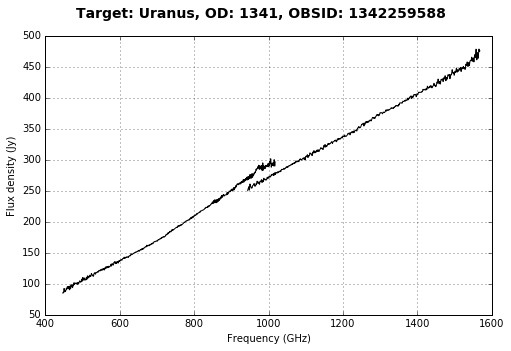

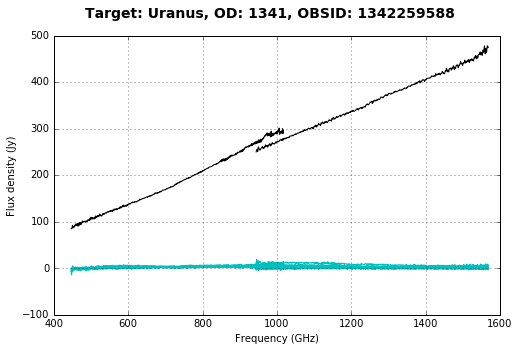

In [7]:
def plotSpireSparseSpec(specIn, fitsHeader=None, onlyCentral=True):
    """
    """
    central = ['SSWD4','SLWC3']
    fig = plt.figure(figsize=(8,5))
    for det in central:
        plt.plot(specIn[det]['wave'],specIn[det]['flux'],'k-')
    if (not onlyCentral): 
        for det in specIn.keys():
            if (not det in central):
                plt.plot(specIn[det]['wave'],specIn[det]['flux'],'c-')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Flux density (Jy)')
    plt.grid(True)
    if (fitsHeader):
        titleText = 'Target: %s, OD: %i, OBSID: %i'%(fitsHeader['OBJECT'],fitsHeader['ODNUMBER'],fitsHeader['OBS_ID'])
        fig.suptitle(titleText, fontsize=14, fontweight='bold')
        #plt.title(titleText)
#
plotSpireSparseSpec(spss, fitsHeader=hh)
#
# add the off axis detectors to the plot
plotSpireSparseSpec(spss, fitsHeader=hh, onlyCentral=False)

## What's next?

Use the provided defs and implement: 
 * A background subtraction function.
 * Pointing offset corrector.
 * Semi-extended corrector.
 * FTS footprint plot.

Short-term implementations:
 * Provide similar dictionary for the mapping observations: preCubes and cubes.
 
Long-term ideas:
 * Create special class for FTS sparse spectra, even better, think about storing the spectral data as HDF5 object.
 * Special class for FTS pre-cubes and spectral cubes.
 * Read access to the non-averaged spectral products, i.e. for each detector and each spectral scan.
 
_Ivan Valtchanov_, Herschel Science Centre, March 2016